In [2]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd

# Define parameters
beta = 0.4             # transmission rate
gamma = 0.1            # recovery rate
N = 10000              # total population per age group
age_groups = 4         # assume 4 age groups

# Contact matrix (Mij): rows = Si, cols = Ij
M = np.array([
    [3.0, 1.5, 0.5, 0.2],
    [1.5, 2.5, 1.0, 0.3],
    [0.5, 1.0, 2.0, 1.5],
    [0.2, 0.3, 1.5, 3.0]
])

# Initial conditions for each group: [S, I, R]
initial_conditions = []
for i in range(age_groups):
    S0 = N - 10  # assume 10 initial infections
    I0 = 10
    R0 = 0
    initial_conditions.extend([S0, I0, R0])

# System of ODEs
def age_structured_sir(y, t, beta, gamma, M, N, age_groups):
    dydt = []
    for i in range(age_groups):
        Si = y[i*3]
        Ii = y[i*3 + 1]
        Ri = y[i*3 + 2]
        lambda_i = sum(M[i, j] * y[j*3 + 1] for j in range(age_groups)) / N
        dSdt = -beta * Si * lambda_i
        dIdt = beta * Si * lambda_i - gamma * Ii
        dRdt = gamma * Ii
        dydt.extend([dSdt, dIdt, dRdt])
    return dydt

# Time grid
t = np.linspace(0, 160, 161)

# Solve the ODE system
solution = odeint(age_structured_sir, initial_conditions, t, args=(beta, gamma, M, N, age_groups))

# Reshape the solution into a DataFrame
columns = []
for i in range(age_groups):
    columns.extend([f"S{i}", f"I{i}", f"R{i}"])
df_solution = pd.DataFrame(solution, columns=columns)
df_solution

,S0,I0,R0,S1,I1,R1,S2,I2,R2,S3,I3,R3
0,9990.000000,10.000000,0.000000,9990.000000,10.000000,0.000000,9990.000000,10.000000,0.000000,9990.000000,10.000000,0.000000
1,9925.112046,71.749162,3.138792,9924.009072,72.813264,3.177664,9929.127151,67.856038,3.016811,9929.822384,67.178039,2.999577
2,9485.044747,489.879554,25.075699,9478.164296,496.410881,25.424824,9524.425982,452.175188,23.398831,9533.831186,443.134139,23.034675
3,7224.159716,2618.825328,157.014955,7194.874286,2646.239652,158.886062,7427.568686,2427.285638,145.145676,7480.095430,2377.717814,142.186756
4,2749.186027,6626.811302,624.002671,2700.112767,6670.100783,629.786450,3030.438018,6382.601467,586.960515,3097.904499,6324.439024,577.656477
...,...,...,...,...,...,...,...,...,...,...,...,...
156,0.000009,0.002395,9999.997595,0.000006,0.002392,9999.997601,0.000021,0.002412,9999.997567,0.000021,0.002416,9999.997563
157,0.000009,0.002167,9999.997823,0.000006,0.002165,9999.997829,0.000021,0.002183,9999.997797,0.000021,0.002186,9999.997793
158,0.000009,0.001961,9999.998030,0.000006,0.001959,9999.998035,0.000021,0.001975,9999.998004,0.000021,0.001978,9999.998001
159,0.000009,0.001775,9999.998216,0.000006,0.001772,9999.998222,0.000021,0.001787,9999.998192,0.000021,0.001790,9999.998189


In [9]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from itertools import product

# Parameters
beta = 0.25
gamma = 0.083
N_total = 1000000  # Total population
cities = ['Adams', 'King', 'Ferry', 'Jefferson']
n_groups = len(age_groups)

# Population distribution across age groups
population = np.array([0.25, 0.30, 0.25, 0.20]) * N_total

# Initial conditions: S, I, R
initial_infected = np.array([50, 100, 150, 200])
initial_recovered = np.zeros(n_groups)
initial_susceptible = population - initial_infected

# Hospitalization (hi), ICU (ci), Mortality (mi) rates
h = np.array([0.01, 0.03, 0.1, 0.2])
c = np.array([0.1, 0.2, 0.3, 0.4])
m = np.array([0.001, 0.005, 0.015, 0.04])

# Contact matrix M
M = np.array([
    [4, 2, 1, 0.5],
    [2, 6, 3, 1],
    [1, 3, 4, 2],
    [0.5, 1, 2, 3]
])

# ODE system
def age_structured_sir(y, t, beta, gamma, M, N):
    S = y[:n_groups]
    I = y[n_groups:2*n_groups]
    R = y[2*n_groups:3*n_groups]
    dSdt = -beta * S * (M @ I) / N
    dIdt = beta * S * (M @ I) / N - gamma * I
    dRdt = gamma * I
    return np.concatenate([dSdt, dIdt, dRdt])

# Time grid
t = np.linspace(0, 100, 1001)

# Initial state vector
y0 = np.concatenate([initial_susceptible, initial_infected, initial_recovered])

# Integrate ODE
sol = odeint(age_structured_sir, y0, t, args=(beta, gamma, M, population))

# Extract results
S, I, R = sol[:, :n_groups], sol[:, n_groups:2*n_groups], sol[:, 2*n_groups:]

# Compute cumulative hospitalizations, ICU, and deaths
peak_inf = np.max(I, axis=0) / population
total_inf = R[-1] / population
H = gamma * h * np.trapz(I, t, axis=0)
ICU = gamma * h * c * np.trapz(I, t, axis=0)
Deaths = gamma * m * np.trapz(I, t, axis=0)

# Prepare output DataFrame
df = pd.DataFrame({
    "Cities": cities,
    "Peak Inf": peak_inf,
    "Total Inf": total_inf,
    "Total Hospitalized": H / population,
    "Total ICU": ICU / population,
    "Mort. Rate": Deaths / population
})

df

,Cities,Peak Inf,Total Inf,Total Hospitalized,Total ICU,Mort. Rate
0,Adams,0.832304,0.999666,0.009997,0.001000,0.001000
1,King,0.857145,0.999676,0.029990,0.005998,0.004998
2,Ferry,0.852815,0.999674,0.099967,0.029990,0.014995
3,Jefferson,0.830138,0.999667,0.199933,0.079973,0.039987



--- Adams ---
Peak infected fraction:    [1.032 0.77  0.823 0.933 1.093 1.352 1.668 2.519 4.368]
Total infected fraction:   [0.25  0.2   0.167 0.187 0.231 0.3   0.375 0.6   1.   ]
Total hospitalized frac:   [0.068 0.055 0.045 0.051 0.063 0.082 0.102 0.164 0.273]
Total ICU fraction:        [0.048 0.039 0.032 0.036 0.045 0.058 0.073 0.116 0.194]
Mortality rate:            [0.023 0.019 0.015 0.017 0.021 0.028 0.035 0.056 0.093]


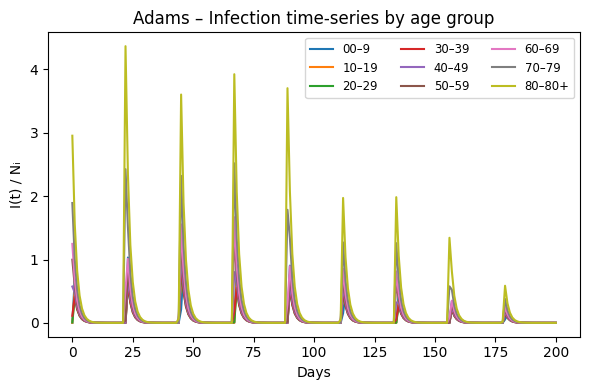


--- King ---
Peak infected fraction:    [1.134 0.841 0.838 0.831 0.891 1.304 2.021 2.671 4.22 ]
Total infected fraction:   [0.273 0.214 0.176 0.176 0.2   0.273 0.429 0.6   1.   ]
Total hospitalized frac:   [0.074 0.058 0.048 0.048 0.055 0.074 0.117 0.164 0.273]
Total ICU fraction:        [0.053 0.041 0.034 0.034 0.039 0.053 0.083 0.116 0.194]
Mortality rate:            [0.025 0.02  0.016 0.016 0.019 0.025 0.04  0.056 0.093]


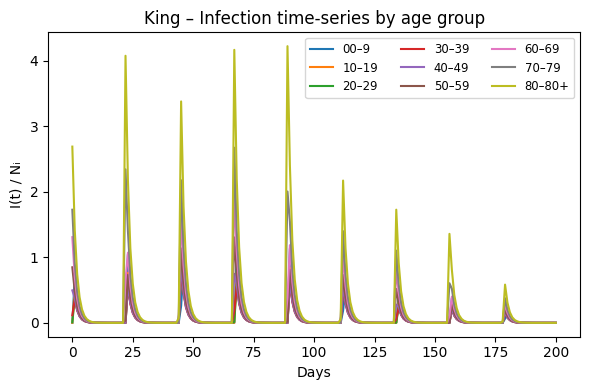


--- Ferry ---
Peak infected fraction:    [1.319 0.957 0.858 0.774 0.749 1.143 1.469 2.068 4.508]
Total infected fraction:   [0.3   0.231 0.2   0.187 0.187 0.25  0.333 0.5   1.   ]
Total hospitalized frac:   [0.082 0.063 0.055 0.051 0.051 0.068 0.091 0.136 0.273]
Total ICU fraction:        [0.058 0.045 0.039 0.036 0.036 0.048 0.065 0.097 0.194]
Mortality rate:            [0.028 0.021 0.019 0.017 0.017 0.023 0.031 0.046 0.093]


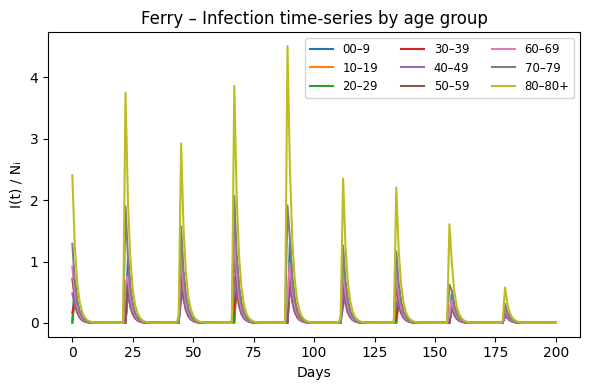


--- Jefferson ---
Peak infected fraction:    [1.72  1.293 1.007 0.756 0.747 0.918 1.103 1.694 2.871]
Total infected fraction:   [0.625 0.5   0.417 0.333 0.294 0.357 0.455 0.625 1.   ]
Total hospitalized frac:   [0.171 0.136 0.114 0.091 0.08  0.097 0.124 0.171 0.273]
Total ICU fraction:        [0.121 0.097 0.081 0.065 0.057 0.069 0.088 0.121 0.194]
Mortality rate:            [0.058 0.046 0.039 0.031 0.027 0.033 0.042 0.058 0.093]


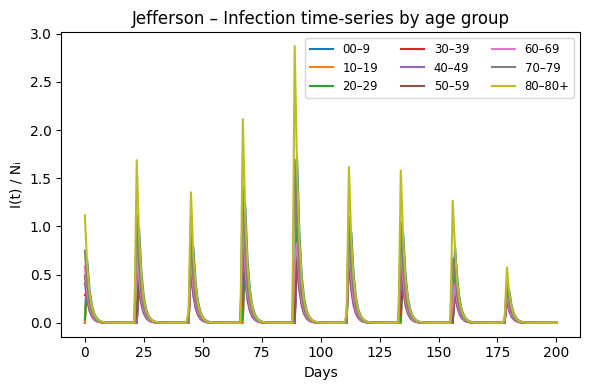

In [14]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# 1) Age‑contact matrix M (9×9) from Figure 1
M = np.array([
    [19.2,  4.8,  3.0,  7.1,  3.7,  3.1,  2.3, 1.4, 1.4],
    [ 4.8, 42.4,  6.4,  5.4,  7.5,  5.0,  1.8, 1.7, 1.7],
    [ 3.0,  6.4, 20.7,  9.2,  7.1,  6.3,  2.0, 0.9, 0.9],
    [ 7.1,  5.4,  9.2, 16.9, 10.1,  6.8,  3.4, 1.5, 1.5],
    [ 3.7,  7.5,  7.1, 10.1, 13.1,  7.4,  2.6, 2.1, 2.1],
    [ 3.1,  5.0,  6.3,  6.8,  7.4, 10.4,  3.5, 1.8, 1.8],
    [ 2.3,  1.8,  2.0,  3.4,  2.6,  3.5,  7.5, 3.2, 3.2],
    [ 1.4,  1.7,  0.9,  1.5,  2.1,  1.8,  3.2, 7.2, 7.2],
    [ 1.4,  1.7,  0.9,  1.5,  2.1,  1.8,  3.2, 7.2, 7.2],
])

# 2) Clinical rates hᵢ, cᵢ, mᵢ from Figure 2 (percent → fraction)
h = np.array([0.001 , 0.003 , 0.012 , 0.032 , 0.049 , 0.102 , 0.166 , 0.243 , 0.273 ])  # hospitalization rates
c = np.array([0.05  , 0.05  , 0.05  , 0.05  , 0.063 , 0.122 , 0.274 , 0.432 , 0.709 ])  # ICU‐among‐hosp
m = np.array([0.00002, 0.00006, 0.00030, 0.00080, 0.00150, 0.00600, 0.02200, 0.05100, 0.09300])  # mortality

# 3) Age‐distributions pᵢ (sum to 1) for the four Washington counties (Figure 7)
counties = {
    "Adams":     np.array([0.12,0.15,0.18,0.16,0.13,0.10,0.08,0.05,0.03]),
    "King":      np.array([0.11,0.14,0.17,0.17,0.15,0.11,0.07,0.05,0.03]),
    "Ferry":     np.array([0.10,0.13,0.15,0.16,0.16,0.12,0.09,0.06,0.03]),
    "Jefferson": np.array([0.08,0.10,0.12,0.15,0.17,0.14,0.11,0.08,0.05]),
}

# 4) Fixed parameters
gamma     = 1/14.0    # removal rate (1/14 days)
R0_target = 5.7       # basic reproduction number
kappa     = 0.1       # social‐distancing strictness coefficient
Cmax100k  = 34.7      # ICU beds per 100k residents
t         = np.linspace(0, 200, 201)  # time grid (days)

def simulate(county_name, p, N_total=1e6):
    # absolute population in each age‐bracket
    N_i = p * N_total

    # calibrate β so that the early‐time R₀ = 5.7
    λ1   = max(np.linalg.eigvals(M * p[np.newaxis,:]).real)
    beta = R0_target * gamma / λ1

    # ICU capacity in absolute beds
    C_max = (Cmax100k / 1e5) * N_total

    # initial conditions: 10 infections per bracket
    S0 = N_i - 10
    I0 = np.full(9, 10.0)
    R0 = np.zeros(9)
    H0 = C0 = D0 = np.zeros(9)
    y0 = np.concatenate([S0, I0, R0, H0, C0, D0])

    def dydt(y, _t):
        S, I, R, H, Cc, D = np.split(y, 6)
        current_ICU = Cc.sum()

        # reactive mitigation: scale contact matrix
        M_eff = M / (1 + kappa * current_ICU / C_max)
        λ     = (M_eff @ I) / N_i

        dS  = -beta * S * λ
        dI  =  beta * S * λ - gamma * I
        dR  =  gamma * I
        dH  =  gamma * h * I
        dCc =  gamma * h * c * I
        dD  =  gamma * m * I

        return np.concatenate([dS, dI, dR, dH, dCc, dD])

    sol = odeint(dydt, y0, t)

    # reshape: (time × 6×9)
    S, I, R, H, Cc, D = sol.T.reshape(6, -1, 9)

    # compute metrics
    peak_inf   = I.max(axis=0) / N_i
    total_inf  = R[-1]    / N_i
    hosp_frac  = H[-1]    / N_i
    icu_frac   = Cc[-1]   / N_i
    mort_rate  = D[-1]    / N_i

    print(f"\n--- {county_name} ---")
    print("Peak infected fraction:   ", np.round(peak_inf, 3))
    print("Total infected fraction:  ", np.round(total_inf, 3))
    print("Total hospitalized frac:  ", np.round(hosp_frac, 3))
    print("Total ICU fraction:       ", np.round(icu_frac, 3))
    print("Mortality rate:           ", np.round(mort_rate, 3))

    # plot age‑specific infection curves
    plt.figure(figsize=(6,4))
    for i in range(9):
        plt.plot(t, I[:,i]/N_i[i], label=f"{10*i:02d}–{10*i+9 if i<8 else '80+'}")
    plt.title(f"{county_name} – Infection time‐series by age group")
    plt.xlabel("Days")
    plt.ylabel("I(t) / Nᵢ")
    plt.legend(ncol=3, fontsize="small")
    plt.tight_layout()
    plt.show()

# Run simulations for all four counties
for name,p in counties.items():
    simulate(name, p)



--- King ---
Peak infected fraction:    [1.134 0.841 0.838 0.831 0.891 1.304 2.021 2.671 4.22 ]
Total infected fraction:   [0.273 0.214 0.176 0.176 0.2   0.273 0.429 0.6   1.   ]
Total hospitalized frac:   [0.074 0.058 0.048 0.048 0.055 0.074 0.117 0.164 0.273]
Total ICU fraction:        [0.053 0.041 0.034 0.034 0.039 0.053 0.083 0.116 0.194]
Mortality rate:            [0.025 0.02  0.016 0.016 0.019 0.025 0.04  0.056 0.093]


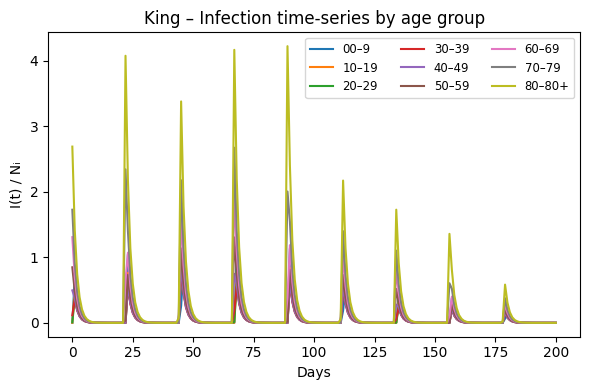

In [15]:
# … everything else exactly as before …

if __name__ == "__main__":
    # Option 1: hard‑code a single county
    simulate("King", counties["King"])

    # Option 2: ask the user at runtime
    # city = input("Enter county (Adams, King, Ferry, Jefferson): ")
    # simulate(city, counties[city])
何沛霖